In [8]:
! git clone https://github.com/chrishon/capstone-camera-traps.git
%cd capstone-camera-traps

Cloning into 'capstone-camera-traps'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 64 (delta 21), reused 55 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 351.73 KiB | 8.58 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/capstone-camera-traps/capstone-camera-traps


In [9]:
import video_processing
import torch

In [10]:
from video_processing.prepare_data import extract_frames, prepare_train_data, prepare_train_data_diffusion

In [11]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [12]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=64,
    in_channels=3 + 5*3,  # Noisy image (3) + condition (5*3)
    out_channels=3,       # Predict noise
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(18, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(1

In [13]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from torch.utils.data import DataLoader, TensorDataset
# 1. Extract and prepare data
video_path="/content/drive/MyDrive/capstone-camera-traps/resources/videos/FH102_02 (1).avi"
frames = extract_frames(video_path)

In [16]:
frames = frames[:7000]

In [17]:
len(frames)

7000

In [18]:

X_condition, y_target = prepare_train_data_diffusion(frames, sequence_length=5)

# 2. Create dataloader
X_tensor = torch.tensor(X_condition, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. Verify shapes
sample_batch = next(iter(train_loader))
condition_batch, target_batch = sample_batch
print(f"Condition shape: {condition_batch.shape}")  # Should be (batch, 15, 64, 64)
print(f"Target shape: {target_batch.shape}")        # Should be (batch, 3, 64, 64)

Condition shape: torch.Size([8, 15, 64, 64])
Target shape: torch.Size([8, 3, 64, 64])


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
for epoch in range(num_epochs):
    i = 1
    for batch_condition, batch_target in train_loader:
        print(i)
        i += 1
        batch_condition = batch_condition.to(device)
        batch_target = batch_target.to(device)

        # Sample noise and timesteps
        noise = torch.randn_like(batch_target)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                 (batch_target.shape[0],), device=device)

        # Add noise to targets
        noisy_images = noise_scheduler.add_noise(batch_target, noise, timesteps)

        # Combine with condition and predict noise
        model_input = torch.cat([noisy_images, batch_condition], dim=1)
        noise_pred = model(model_input, timesteps).sample

        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

1


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
4

In [20]:
def predict_next_frame(model, condition, scheduler, device):
    model.eval()
    with torch.no_grad():
        # Initial noise
        sample = torch.randn((1, 3, 64, 64), device=device)
        condition = condition.unsqueeze(0).to(device)

        # Denoising loop
        for t in scheduler.timesteps:
            model_input = torch.cat([sample, condition], dim=1)
            noise_pred = model(model_input, t).sample
            sample = scheduler.step(noise_pred, t, sample).prev_sample

        # Denormalize and format
        predicted_frame = sample.squeeze().cpu().numpy()
        predicted_frame = (predicted_frame + 1) / 2  # [0, 1]
        predicted_frame = np.transpose(predicted_frame, (1, 2, 0))
        return predicted_frame

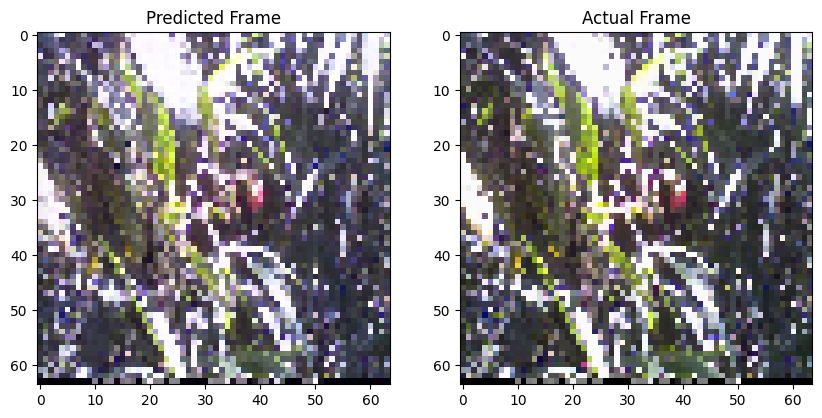

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare test data
X_condition_test, y_test = X_condition, y_target
# X_condition_test, y_test = prepare_train_data(test_frames)

# Select sample
sample_idx = 3
condition_sample = torch.tensor(X_condition_test[sample_idx], dtype=torch.float32)
actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2  # To HWC and [0,1]

# Generate prediction
predicted_frame = predict_next_frame(model, condition_sample, noise_scheduler, device)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(predicted_frame)
plt.title("Predicted Frame")
plt.subplot(1, 2, 2)
plt.imshow(actual_frame)
plt.title("Actual Frame")
plt.show()

In [22]:
from video_processing.post_processing import frame_analysis, visualize_comparison, temporal_analysis

In [23]:
analysis_results = frame_analysis(predicted_frame, actual_frame)
analysis_results

{'mean_absolute_error': 0.07835728,
 'max_absolute_error': 0.8673085,
 'ssim': 0.8105481,
 'patch_diff': array([0.13505162, 0.09708232, 0.04256853, 0.0929578 , 0.09381255,
        0.12114993, 0.09231546, 0.06597384, 0.09074449, 0.10420666,
        0.07682038, 0.04443371, 0.04234117, 0.04382126, 0.06599651,
        0.0444403 ], dtype=float32)}

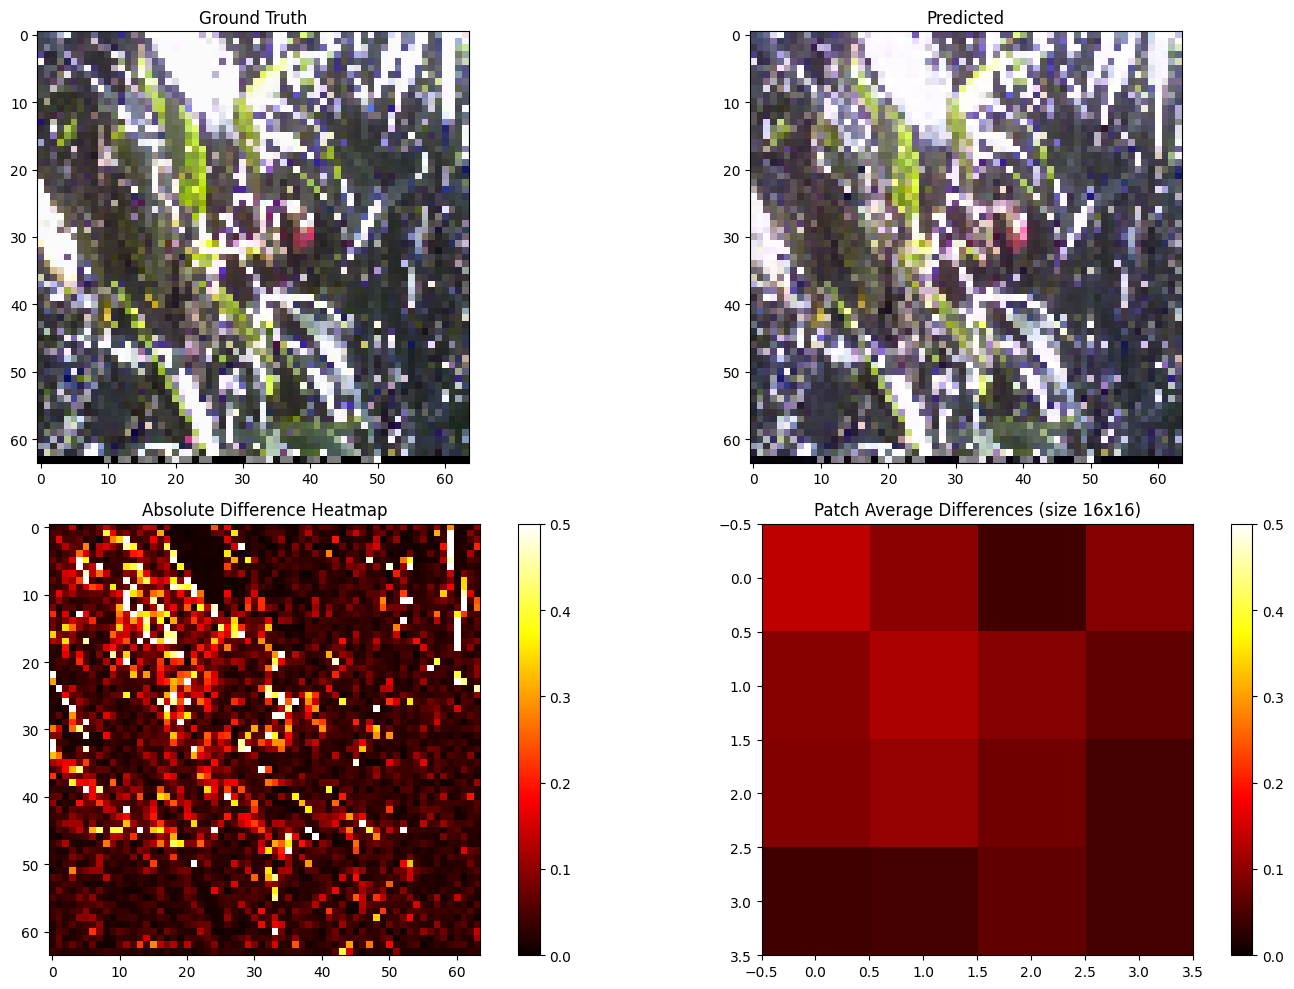

In [24]:
visualize_comparison(predicted_frame, actual_frame)